In [1]:
from configobj import ConfigObj
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pyccl as ccl
import scipy
from matplotlib.pyplot import cm
#from HiCOLA import Frontend

## Get expansion and force files

Power spectra at "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid.dat"

Expansion and force at "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_today/horndeski_model_run_10_expansion.txt"

Expansion and force at "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_today/horndeski_model_run_10_force.txt"

# from paper
wr = 0.0#4.28e-5
wc = 0.11933
wb = 0.02242
h = 0.6766

# We assume:
A_s = 2.1e-9
n_s = 0.966

# Derived params
Omg_r = wr/h**2
Omg_m = (wc+wb)/h**2
Omg_b = wb/h**2

f_phi = 0.5310526315789474
k1_tracker = -2.1997003752018447

In [4]:
# Create cola folders - only need to do this once

# CAREFUL!! might not need this next step
#command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu/Output_backend/COLA_seeds'
#os.system(command)
#os.system("cd; cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/; mkdir COLA_seeds")


0

# Run Frontend

In [189]:
def rewriteluafile(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    
    # from paper
    wr = 0.0#4.28e-5
    wc = 0.11933
    wb = 0.02242
    h = 0.6766

    wm = wc + wb
    # We assume:
    A_s = 2.1e-9
    n_s = 0.966
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = (wc+wb)/h**2
    Omg_b = wb/h**2
    
    f_phi = 0.5310526315789474
    k1_tracker = -2.1997003752018447
    
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_10_expansion.txt"'.format(str(k))+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_10_force.txt"'.format(str(k))+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds"'+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')  
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid_backscaled.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

# Same as above
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'



In [190]:
"""Re-write lua file"""
for i in range(10):
    rewriteluafile(i,txt,400,512,1536)


In [ ]:
"""Create Pk"""
for i in range(10):
    os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}.lua".format(str(i)))
    


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

In [ ]:
"""Create Pk"""
for i in range(8,9):
    os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}.lua".format(str(i)))
    


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

# Run GR Frontend

In [14]:
# Create cola folders - only need to do this once

# CAREFUL!! might not need this next step
#command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu/Output_backend/COLA_seeds_GR'
#os.system(command)
os.system("cd; cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/; mkdir COLA_seeds_GR")


0

In [ ]:
def rewriteluafile(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    
    # from paper
    wr = 0.0#4.28e-5
    wc = 0.11933
    wb = 0.02242
    h = 0.6766

    wm = wc + wb
    # We assume:
    A_s = 2.1e-9
    n_s = 0.966
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = (wc+wb)/h**2
    Omg_b = wb/h**2
    
    f_phi = 0.5310526315789474
    k1_tracker = -2.1997003752018447
    
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}_GR.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_GR"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR"'+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')   
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid_backscaled.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

# Same as above
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'



In [ ]:
"""Re-write lua file"""
for i in range(10):
    rewriteluafile(i,txt,400,512,1536)

In [ ]:
"""Create Pk"""
#for i in range(10):
for i in range(8,9):
    os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}_GR.lua".format(str(i)))
    

# Get phase pair

In [242]:
"""Create phase pair Pk"""

def rewriteluafile_phase(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    
    # from paper
    wr = 0.0#4.28e-5
    wc = 0.11933
    wb = 0.02242
    h = 0.6766

    wm = wc + wb
    # We assume:
    A_s = 2.1e-9
    n_s = 0.966
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = (wc+wb)/h**2
    Omg_b = wb/h**2
    
    f_phi = 0.5310526315789474
    k1_tracker = -2.1997003752018447
    
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}_phasepair.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_phase"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_10_expansion.txt"'.format(str(k))+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_10_force.txt"'.format(str(k))+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds"'+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid_backscaled.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

# Same as above
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'



In [243]:
"""Create phase pair Pk"""
i = 8
rewriteluafile_phase(i,txt,400,512,1536)
os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}_phasepair.lua".format(str(i)))


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [244]:
"""Create phase pair Pk"""
def rewriteluafile_phase(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    
    # from paper
    wr = 0.0#4.28e-5
    wc = 0.11933
    wb = 0.02242
    h = 0.6766

    wm = wc + wb
    # We assume:
    A_s = 2.1e-9
    n_s = 0.966
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = (wc+wb)/h**2
    Omg_b = wb/h**2
    
    f_phi = 0.5310526315789474
    k1_tracker = -2.1997003752018447
    
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}_GR_phasepair.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_phase_GR"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR"'+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')   
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n')
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid_backscaled.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

# Same as above
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'



In [245]:
"""Create phase pair Pk"""
i = 8
rewriteluafile_phase(i,txt,400,512,1536)

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Seeds/Hi-COLA_params_emu_seed_{}_GR_phasepair.lua".format(str(i)))


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

# Plot and look at P(k)

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

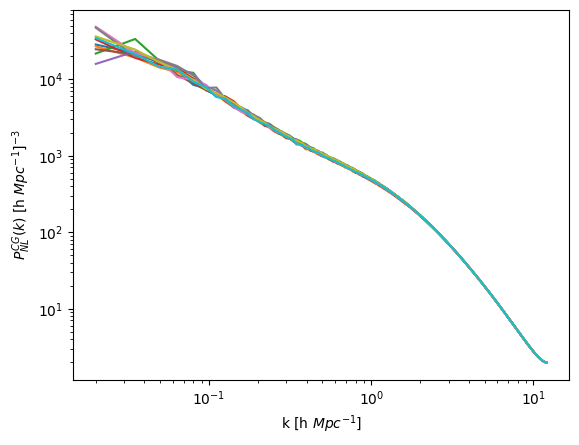

In [2]:
"""Plotting the NL power spectra for the simulations at z = 0"""

for i in range(10):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.000.txt".format(i)).T
    plt.plot(k,Pk_NL)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

In [3]:
k, Pk_NL0,Pk_Lin0 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL1,Pk_Lin1 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_1_cb_z0.000.txt").T
k, Pk_NL2,Pk_Lin2 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_2_cb_z0.000.txt").T
k, Pk_NL3,Pk_Lin3 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_3_cb_z0.000.txt").T
k, Pk_NL4,Pk_Lin4 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_4_cb_z0.000.txt").T
k, Pk_NL5,Pk_Lin5 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_5_cb_z0.000.txt").T
k, Pk_NL6,Pk_Lin6 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_6_cb_z0.000.txt").T
k, Pk_NL7,Pk_Lin7 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_7_cb_z0.000.txt").T
k, Pk_NL8,Pk_Lin8 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_8_cb_z0.000.txt").T
k, Pk_NL9,Pk_Lin9 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_9_cb_z0.000.txt").T




Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

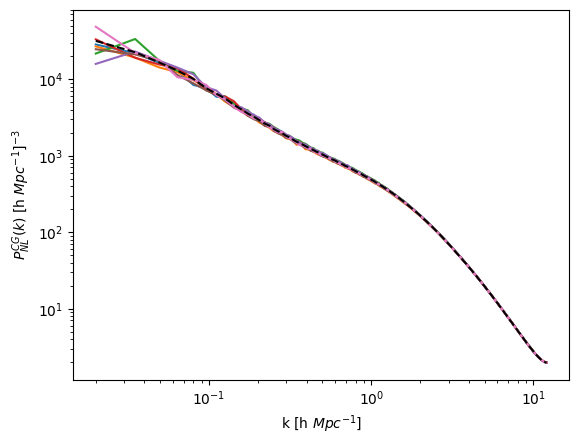

In [4]:

for i in range(7):#10):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.000.txt".format(i)).T
    plt.plot(k,Pk_NL)
    
Pk_NL_avg = np.mean(np.array([Pk_NL0,Pk_NL1,Pk_NL2,Pk_NL3,Pk_NL4,Pk_NL5,Pk_NL6,Pk_NL7,Pk_NL8,Pk_NL9]), axis = 0)

plt.plot(k,Pk_NL_avg, "k--")

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

In [5]:
log_Pk_smoothed0 = scipy.signal.savgol_filter(np.log(Pk_NL0), 51, 3)
log_Pk_smoothed1 = scipy.signal.savgol_filter(np.log(Pk_NL1), 51, 3)
log_Pk_smoothed2 = scipy.signal.savgol_filter(np.log(Pk_NL2), 51, 3)
log_Pk_smoothed3 = scipy.signal.savgol_filter(np.log(Pk_NL3), 51, 3)
log_Pk_smoothed4 = scipy.signal.savgol_filter(np.log(Pk_NL4), 51, 3)
log_Pk_smoothed5 = scipy.signal.savgol_filter(np.log(Pk_NL5), 51, 3)
log_Pk_smoothed6 = scipy.signal.savgol_filter(np.log(Pk_NL6), 51, 3)
log_Pk_smoothed7 = scipy.signal.savgol_filter(np.log(Pk_NL7), 51, 3)
log_Pk_smoothed8 = scipy.signal.savgol_filter(np.log(Pk_NL8), 51, 3)
log_Pk_smoothed9 = scipy.signal.savgol_filter(np.log(Pk_NL9), 51, 3)

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

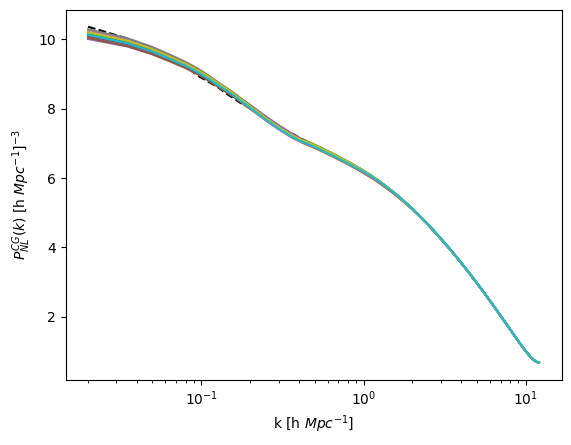

In [6]:

plt.plot(k,np.log(Pk_NL_avg), "k--")
plt.plot(k,log_Pk_smoothed0)
plt.plot(k,log_Pk_smoothed1)
plt.plot(k,log_Pk_smoothed2)
plt.plot(k,log_Pk_smoothed3)
plt.plot(k,log_Pk_smoothed4)
plt.plot(k,log_Pk_smoothed5)
plt.plot(k,log_Pk_smoothed6)
plt.plot(k,log_Pk_smoothed7)
plt.plot(k,log_Pk_smoothed8)
plt.plot(k,log_Pk_smoothed9)

plt.xscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

## Analysing the Boost initial conditions: average over B

In [7]:
k, Pk_NL0_GR,Pk_Lin0_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T
k, Pk_NL1_GR,Pk_Lin1_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_1_GR_cb_z0.000.txt").T
k, Pk_NL2_GR,Pk_Lin2_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_2_GR_cb_z0.000.txt").T
k, Pk_NL3_GR,Pk_Lin3_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_3_GR_cb_z0.000.txt").T
k, Pk_NL4_GR,Pk_Lin4_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_4_GR_cb_z0.000.txt").T
k, Pk_NL5_GR,Pk_Lin5_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_5_GR_cb_z0.000.txt").T
k, Pk_NL6_GR,Pk_Lin6_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_6_GR_cb_z0.000.txt").T
k, Pk_NL7_GR,Pk_Lin7_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_7_GR_cb_z0.000.txt").T
k, Pk_NL8_GR,Pk_Lin8_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_8_GR_cb_z0.000.txt").T
k, Pk_NL9_GR,Pk_Lin9_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_9_GR_cb_z0.000.txt").T


Bk0 = Pk_NL0/Pk_NL0_GR
Bk1 = Pk_NL1/Pk_NL1_GR
Bk2 = Pk_NL2/Pk_NL2_GR
Bk3 = Pk_NL3/Pk_NL3_GR
Bk4 = Pk_NL4/Pk_NL4_GR
Bk5 = Pk_NL5/Pk_NL5_GR
Bk6 = Pk_NL6/Pk_NL6_GR
Bk7 = Pk_NL7/Pk_NL7_GR
Bk8 = Pk_NL8/Pk_NL8_GR
Bk9 = Pk_NL9/Pk_NL9_GR

Text(0, 0.5, '$P^{GR}_{NL}(k)/P^{GR,0}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

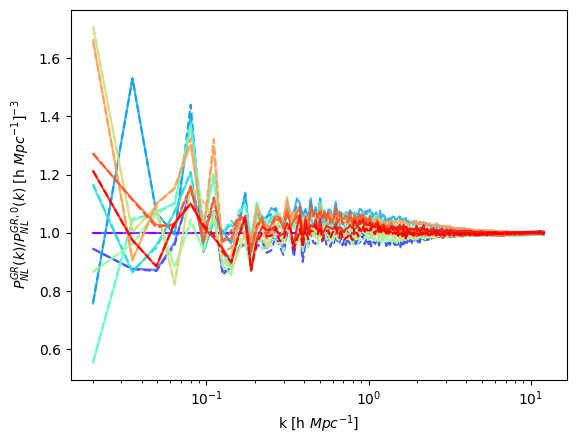

In [8]:
"""Plotting the NL power spectra for the simulations at z = 0"""

color = cm.rainbow(np.linspace(0, 1, 10))

for i in range(10):
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_{}_GR_cb_z0.000.txt".format(i)).T
    plt.plot(k,Pk_NL_GR/Pk_NL0_GR, color=color[i], alpha=0.8)
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.000.txt".format(i)).T
    plt.plot(k,Pk_NL/Pk_NL0, color=color[i], linestyle = "--", alpha=1.0)
    
plt.xscale("log")
#plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{GR}_{NL}(k)/P^{GR,0}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

In [9]:
Bk_smoothed0 = scipy.signal.savgol_filter(Bk0, 51, 3)
Bk_smoothed1 = scipy.signal.savgol_filter(Bk1, 51, 3)
Bk_smoothed2 = scipy.signal.savgol_filter(Bk2, 51, 3)
Bk_smoothed3 = scipy.signal.savgol_filter(Bk3, 51, 3)
Bk_smoothed4 = scipy.signal.savgol_filter(Bk4, 51, 3)
Bk_smoothed5 = scipy.signal.savgol_filter(Bk5, 51, 3)
Bk_smoothed6 = scipy.signal.savgol_filter(Bk6, 51, 3)
Bk_smoothed7 = scipy.signal.savgol_filter(Bk7, 51, 3)
Bk_smoothed8 = scipy.signal.savgol_filter(Bk8, 51, 3)
Bk_smoothed9 = scipy.signal.savgol_filter(Bk9, 51, 3)

Text(0, 0.5, 'B(z)')

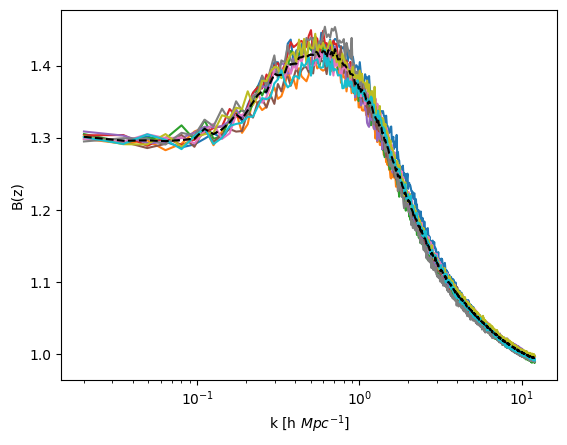

In [10]:

Bk_avg = np.mean(np.array([Bk0,Bk1,Bk2,Bk3,Bk4,Bk5,Bk6,Bk7,Bk8,Bk9]), axis = 0)
Bk_avg_smoothed = scipy.signal.savgol_filter(Bk_avg, 51, 3)

plt.plot(k,Bk_avg, "k--")
plt.plot(k,Bk0)
plt.plot(k,Bk1)
plt.plot(k,Bk2)
plt.plot(k,Bk3)
plt.plot(k,Bk4)
plt.plot(k,Bk5)
plt.plot(k,Bk6)
plt.plot(k,Bk7)
plt.plot(k,Bk8)
plt.plot(k,Bk9)
plt.plot(k,Bk_avg, "k--")



plt.xscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("B(z)")

Text(0, 0.5, 'B(k) smoothed/B(k) avg')

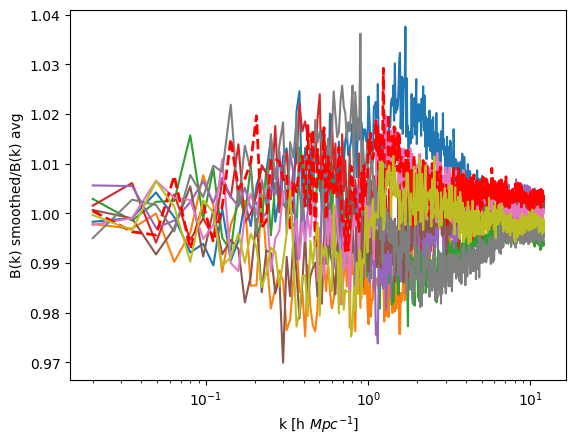

In [11]:


plt.plot(k,Bk0/Bk_avg)
plt.plot(k,Bk1/Bk_avg)
plt.plot(k,Bk2/Bk_avg)
plt.plot(k,Bk3/Bk_avg)
plt.plot(k,Bk4/Bk_avg)
plt.plot(k,Bk5/Bk_avg)
plt.plot(k,Bk6/Bk_avg)
plt.plot(k,Bk7/Bk_avg)
plt.plot(k,Bk8/Bk_avg, "r--", linewidth=2)
plt.plot(k,Bk9/Bk_avg)



plt.xscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("B(k) smoothed/B(k) avg")

In [12]:
"Check phase pair"

k, Pk_NL8_GR_phase,Pk_Lin8_GR_phase = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_8_phase_GR_cb_z0.000.txt").T
k, Pk_NL8_phase,Pk_Lin8_phase = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_8_phase_cb_z0.000.txt").T


Boost_phasepair = (Pk_NL8_phase/Pk_NL8_GR_phase + Pk_NL8/Pk_NL8_GR)/2



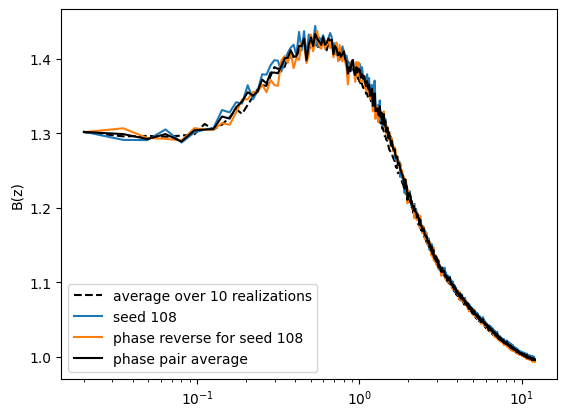

In [13]:
plt.plot(k,Bk_avg, "k--", label = "average over 10 realizations")

plt.plot(k,Bk8, label = "seed 108")
plt.plot(k, Pk_NL8_phase/Pk_NL8_GR_phase, label="phase reverse for seed 108")

plt.plot(k,Boost_phasepair, "k", label = "phase pair average")

plt.xscale("log")
plt.ylabel("B(z)")
plt.legend()

Text(0, 0.5, '$\\frac{B(z)}{B_{avg}(z)}$')

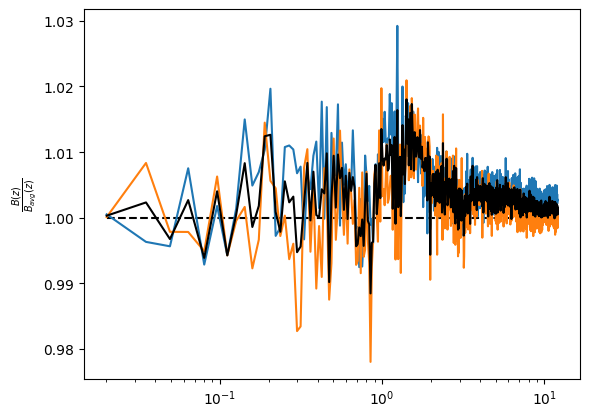

In [14]:
plt.plot(k,Bk_avg/Bk_avg, "k--")


plt.plot(k,Bk8/Bk_avg)

plt.plot(k, Pk_NL8_phase/Pk_NL8_GR_phase/Bk_avg)

plt.plot(k,Boost_phasepair/Bk_avg, "k")

plt.xscale("log")
plt.ylabel(r"$\frac{B(z)}{B_{avg}(z)}$")


Text(0, 0.5, '$\\frac{B(z)}{B_{avg}(z)}$')

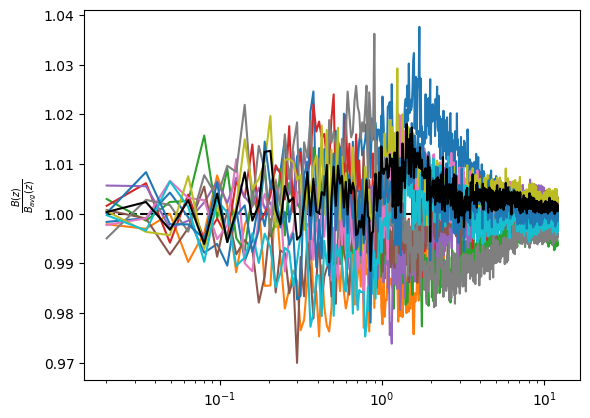

In [15]:
plt.plot(k,Bk_avg/Bk_avg, "k--")


plt.plot(k,Bk0/Bk_avg)
plt.plot(k,Bk1/Bk_avg)
plt.plot(k,Bk2/Bk_avg)
plt.plot(k,Bk3/Bk_avg)
plt.plot(k,Bk4/Bk_avg)
plt.plot(k,Bk5/Bk_avg)
plt.plot(k,Bk6/Bk_avg)
plt.plot(k,Bk7/Bk_avg)
plt.plot(k,Bk8/Bk_avg)
plt.plot(k,Bk9/Bk_avg)

plt.plot(k, Pk_NL8_phase/Pk_NL8_GR_phase/Bk_avg)

plt.plot(k,Boost_phasepair/Bk_avg, "k")

plt.xscale("log")
plt.ylabel(r"$\frac{B(z)}{B_{avg}(z)}$")


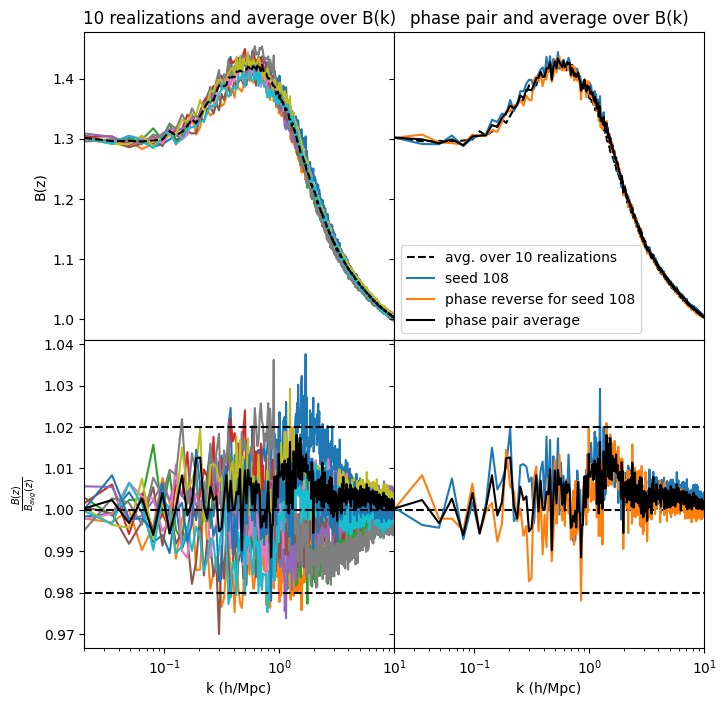

In [16]:
"""Plotting the NL power spectra for the simulations at z = 0"""

fig, ax = plt.subplots(2,2, sharex=True, sharey='row', figsize=(8,8))
fig.subplots_adjust(hspace=0,wspace=0)

ax[0][0].plot(k,Bk0)
ax[0][0].plot(k,Bk1)
ax[0][0].plot(k,Bk2)
ax[0][0].plot(k,Bk3)
ax[0][0].plot(k,Bk4)
ax[0][0].plot(k,Bk5)
ax[0][0].plot(k,Bk6)
ax[0][0].plot(k,Bk7)
ax[0][0].plot(k,Bk8)
ax[0][0].plot(k,Bk9)
ax[0][0].plot(k,Bk_avg, "k--")


ax[0][1].plot(k,Bk_avg, "k--", label = "avg. over 10 realizations")
ax[0][1].plot(k,Bk8, label = "seed 108")
ax[0][1].plot(k, Pk_NL8_phase/Pk_NL8_GR_phase, label="phase reverse for seed 108")
ax[0][1].plot(k,Boost_phasepair, "k", label = "phase pair average")

ax[1][0].plot(k,Bk0/Bk_avg)
ax[1][0].plot(k,Bk1/Bk_avg)
ax[1][0].plot(k,Bk2/Bk_avg)
ax[1][0].plot(k,Bk3/Bk_avg)
ax[1][0].plot(k,Bk4/Bk_avg)
ax[1][0].plot(k,Bk5/Bk_avg)
ax[1][0].plot(k,Bk6/Bk_avg)
ax[1][0].plot(k,Bk7/Bk_avg)
ax[1][0].plot(k,Bk8/Bk_avg)
ax[1][0].plot(k,Bk9/Bk_avg)
ax[1][0].plot(k, Pk_NL8_phase/Pk_NL8_GR_phase/Bk_avg)
ax[1][0].plot(k,Boost_phasepair/Bk_avg, "k")
ax[1][0].plot(k,Bk_avg/Bk_avg, "k--")
ax[1][0].plot(k,Bk_avg/Bk_avg*1.02, "k--")
ax[1][0].plot(k,Bk_avg/Bk_avg*0.98, "k--")

ax[1][1].plot(k,Bk_avg/Bk_avg, "k--")
ax[1][1].plot(k,Bk8/Bk_avg)
ax[1][1].plot(k, Pk_NL8_phase/Pk_NL8_GR_phase/Bk_avg)
ax[1][1].plot(k,Boost_phasepair/Bk_avg, "k")
ax[1][1].plot(k,Bk_avg/Bk_avg*1.02, "k--")
ax[1][1].plot(k,Bk_avg/Bk_avg*0.98, "k--")

ax[0][0].set_xscale("log")
ax[0][0].set_title("10 realizations and average over B(k)")
ax[0][1].set_title("phase pair and average over B(k)")
ax[0][0].set_ylabel("B(z)")
ax[1][0].set_ylabel(r"$\frac{B(z)}{B_{avg}(z)}$")
ax[0][0].set_xlim(2e-2,10)
ax[0][1].legend()
ax[1][1].set_xlabel("k (h/Mpc)")
ax[1][0].set_xlabel("k (h/Mpc)")
plt.savefig("IC_tests_Bavg")
plt.show()

## Analysing the Boost initial conditions: average over power spec

In [19]:
P_NL_avg = np.mean(np.array([Pk_NL0,Pk_NL1,Pk_NL2,Pk_NL3,Pk_NL4,Pk_NL5,Pk_NL6,Pk_NL7,Pk_NL8,Pk_NL9]), axis = 0)
P_NL_GR_avg = np.mean(np.array([Pk_NL0_GR,Pk_NL1_GR,Pk_NL2_GR,Pk_NL3_GR,Pk_NL4_GR,Pk_NL5_GR,Pk_NL6_GR,Pk_NL7_GR,Pk_NL8_GR,Pk_NL9_GR]), axis = 0)

Boost_phasepair_Pavg = (Pk_NL8_phase + Pk_NL8)/(Pk_NL8_GR_phase + Pk_NL8_GR)
Bk_Pavg = P_NL_avg/P_NL_GR_avg


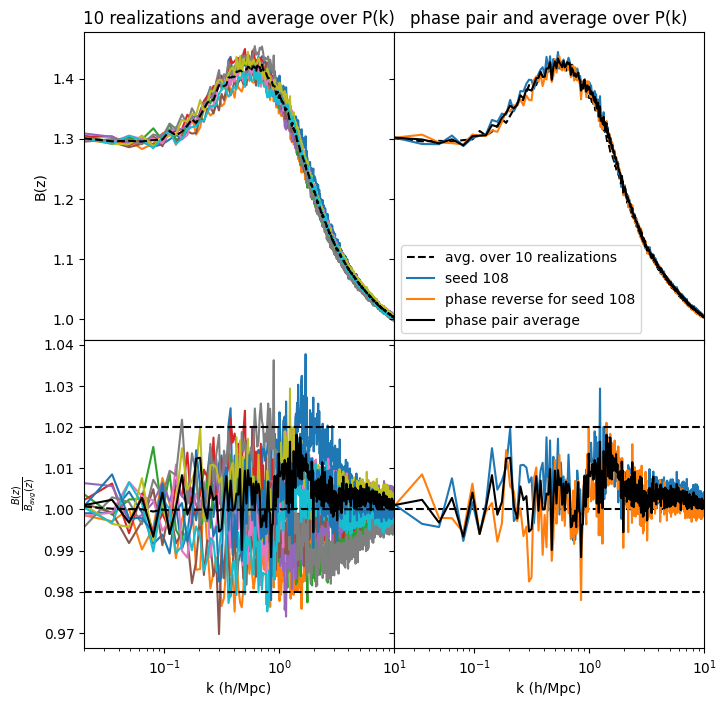

In [20]:
"""Plotting the NL power spectra for the simulations at z = 0"""

fig, ax = plt.subplots(2,2, sharex=True, sharey='row', figsize=(8,8))
fig.subplots_adjust(hspace=0,wspace=0)

ax[0][0].plot(k,Bk0)
ax[0][0].plot(k,Bk1)
ax[0][0].plot(k,Bk2)
ax[0][0].plot(k,Bk3)
ax[0][0].plot(k,Bk4)
ax[0][0].plot(k,Bk5)
ax[0][0].plot(k,Bk6)
ax[0][0].plot(k,Bk7)
ax[0][0].plot(k,Bk8)
ax[0][0].plot(k,Bk9)
ax[0][0].plot(k,Bk_Pavg, "k--")


ax[0][1].plot(k,Bk_Pavg, "k--", label = "avg. over 10 realizations")
ax[0][1].plot(k,Bk8, label = "seed 108")
ax[0][1].plot(k, Pk_NL8_phase/Pk_NL8_GR_phase, label="phase reverse for seed 108")
ax[0][1].plot(k,Boost_phasepair_Pavg, "k", label = "phase pair average")

ax[1][0].plot(k,Bk0/Bk_Pavg)
ax[1][0].plot(k,Bk1/Bk_Pavg)
ax[1][0].plot(k,Bk2/Bk_Pavg)
ax[1][0].plot(k,Bk3/Bk_Pavg)
ax[1][0].plot(k,Bk4/Bk_Pavg)
ax[1][0].plot(k,Bk5/Bk_Pavg)
ax[1][0].plot(k,Bk6/Bk_Pavg)
ax[1][0].plot(k,Bk7/Bk_Pavg)
ax[1][0].plot(k,Bk8/Bk_Pavg)
ax[1][0].plot(k,Bk9/Bk_Pavg)
ax[1][0].plot(k, Pk_NL8_phase/Pk_NL8_GR_phase/Bk_Pavg)
ax[1][0].plot(k,Boost_phasepair_Pavg/Bk_Pavg, "k")
ax[1][0].plot(k,Bk_avg/Bk_Pavg, "k--")
ax[1][0].plot(k,Bk_avg/Bk_avg*1.02, "k--")
ax[1][0].plot(k,Bk_avg/Bk_avg*0.98, "k--")

ax[1][1].plot(k,Bk_Pavg/Bk_Pavg, "k--")
ax[1][1].plot(k,Bk8/Bk_Pavg)
ax[1][1].plot(k, Pk_NL8_phase/Pk_NL8_GR_phase/Bk_Pavg)
ax[1][1].plot(k,Boost_phasepair_Pavg/Bk_Pavg, "k")
ax[1][1].plot(k,Bk_avg/Bk_avg*1.02, "k--")
ax[1][1].plot(k,Bk_avg/Bk_avg*0.98, "k--")

ax[0][0].set_xscale("log")
ax[0][0].set_title("10 realizations and average over P(k)")
ax[0][1].set_title("phase pair and average over P(k)")
ax[0][0].set_ylabel("B(z)")
ax[1][0].set_ylabel(r"$\frac{B(z)}{B_{avg}(z)}$")
ax[0][0].set_xlim(2e-2,10)
ax[0][1].legend()
ax[1][1].set_xlabel("k (h/Mpc)")
ax[1][0].set_xlabel("k (h/Mpc)")
plt.savefig("IC_tests_Pavg")
plt.show()

# Recover B(k) in npy and zip files

In [13]:
k, Pk_NL0,Pk_Lin0 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL1,Pk_Lin1 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_1_cb_z0.000.txt").T
k, Pk_NL2,Pk_Lin2 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_2_cb_z0.000.txt").T
k, Pk_NL3,Pk_Lin3 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_3_cb_z0.000.txt").T
k, Pk_NL4,Pk_Lin4 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_4_cb_z0.000.txt").T
k, Pk_NL5,Pk_Lin5 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_5_cb_z0.000.txt").T
k, Pk_NL6,Pk_Lin6 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_6_cb_z0.000.txt").T
k, Pk_NL7,Pk_Lin7 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_7_cb_z0.000.txt").T
k, Pk_NL8,Pk_Lin8 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_8_cb_z0.000.txt").T
k, Pk_NL9,Pk_Lin9 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_9_cb_z0.000.txt").T

k, Pk_NL0_GR,Pk_Lin0_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T
k, Pk_NL1_GR,Pk_Lin1_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_1_GR_cb_z0.000.txt").T
k, Pk_NL2_GR,Pk_Lin2_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_2_GR_cb_z0.000.txt").T
k, Pk_NL3_GR,Pk_Lin3_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_3_GR_cb_z0.000.txt").T
k, Pk_NL4_GR,Pk_Lin4_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_4_GR_cb_z0.000.txt").T
k, Pk_NL5_GR,Pk_Lin5_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_5_GR_cb_z0.000.txt").T
k, Pk_NL6_GR,Pk_Lin6_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_6_GR_cb_z0.000.txt").T
k, Pk_NL7_GR,Pk_Lin7_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_7_GR_cb_z0.000.txt").T
k, Pk_NL8_GR,Pk_Lin8_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_8_GR_cb_z0.000.txt").T
k, Pk_NL9_GR,Pk_Lin9_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_9_GR_cb_z0.000.txt").T

k, Pk_NL8_GR_phase,Pk_Lin8_GR_phase = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_8_phase_GR_cb_z0.000.txt").T
k, Pk_NL8_phase,Pk_Lin8_phase = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_8_phase_cb_z0.000.txt").T

Bk0 = Pk_NL0/Pk_NL0_GR
Bk1 = Pk_NL1/Pk_NL1_GR
Bk2 = Pk_NL2/Pk_NL2_GR
Bk3 = Pk_NL3/Pk_NL3_GR
Bk4 = Pk_NL4/Pk_NL4_GR
Bk5 = Pk_NL5/Pk_NL5_GR
Bk6 = Pk_NL6/Pk_NL6_GR
Bk7 = Pk_NL7/Pk_NL7_GR
Bk8 = Pk_NL8/Pk_NL8_GR
Bk9 = Pk_NL9/Pk_NL9_GR

Bk_avg = np.mean(np.array([Bk0,Bk1,Bk2,Bk3,Bk4,Bk5,Bk6,Bk7,Bk8,Bk9]), axis = 0)

Boost_phasepair = (Pk_NL8_phase/Pk_NL8_GR_phase + Pk_NL8/Pk_NL8_GR)/2

Ratio = Boost_phasepair/Bk_avg


In [14]:
"""By the end of this cell, will have 
Ratio = Boost_phasepair/Bk_avg10
k = wavevector
z = redshift"""

Ratio = np.zeros((51,768))

############ CG NL, all seeds ############
# ~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_0_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_0 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 1 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_1_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_1 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 2 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_2_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_2 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 3 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_3_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_3 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 4 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_4_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_4 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 5 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_5_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_5 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 6 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_6_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_6 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 7 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_7_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_7 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 8 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_8_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_8 = Pk_NL[z.argsort()]

# ~~~~~~~~~~~~~~ Seed 9 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_9_cb*', recursive=True):

    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    
    if c == 0:
        Pk_NL = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

    else:
        Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest
Pk_NL_9 = Pk_NL[z.argsort()]
##########################################
############ GR NL, all seeds ############
# ~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_0 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 1 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_1_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_1 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 2 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_2_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_2 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 3 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_3_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_3 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 4 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_4_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_4 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 5 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_5_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_5 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 6 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_6_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_6 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 7 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_7_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_7 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 8 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_8_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_8 = Pk_NL_GR[z.argsort()]
# ~~~~~~~~~~~~~~ Seed 9 ~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_9_GR_cb*', recursive=True):
    k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T    
    if c == 0:
        Pk_NL_GR = [Pk_NL_GR_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
Pk_NL_GR_9 = Pk_NL_GR[z.argsort()]
##########################################
########## CG and GR NL, seed 8 ##########
# ~~~~~~~~~~~~~~~~ CG ~~~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds/pofk_my_new_Hi-COLA_simulation_8_phase_cb*', recursive=True):
    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    if c == 0:
        Pk_NL_pp = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_pp = np.append(Pk_NL_pp, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest 
Pk_NL_pp_8 = Pk_NL_pp[z.argsort()]
# ~~~~~~~~~~~~~~~~ GR ~~~~~~~~~~~~~~~~~~~~
c = 0
for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_seeds_GR/pofk_my_new_Hi-COLA_simulation_8_phase_GR_cb*', recursive=True):
    k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
    if c == 0:
        Pk_NL_pp = [Pk_NL_j]
        z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
    else:
        Pk_NL_pp = np.append(Pk_NL_pp, [Pk_NL_j], axis = 0)
        z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
    c += 1
# sort Pk from lowest to highest 
Pk_NL_pp_GR_8 = Pk_NL_pp[z.argsort()]

z = sorted(z)

In [15]:
Bk0 = Pk_NL_0/Pk_NL_GR_0
Bk1 = Pk_NL_1/Pk_NL_GR_1
Bk2 = Pk_NL_2/Pk_NL_GR_2
Bk3 = Pk_NL_3/Pk_NL_GR_3
Bk4 = Pk_NL_4/Pk_NL_GR_4
Bk5 = Pk_NL_5/Pk_NL_GR_5
Bk6 = Pk_NL_6/Pk_NL_GR_6
Bk7 = Pk_NL_7/Pk_NL_GR_7
Bk8 = Pk_NL_8/Pk_NL_GR_8
Bk9 = Pk_NL_9/Pk_NL_GR_9

Bk_avg = np.mean(np.array([Bk0,Bk1,Bk2,Bk3,Bk4,Bk5,Bk6,Bk7,Bk8,Bk9]), axis = 0)

Boost_phasepair = (Pk_NL_pp_8/Pk_NL_pp_GR_8 + Bk8)/2

Ratio = Boost_phasepair/Bk_avg

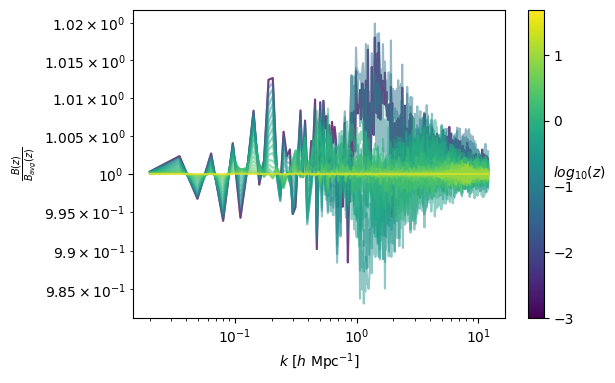

In [16]:
"""Plotting the NL power spectra for the simulations at z = 0"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['viridis']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = np.log10(np.array(z) + 1e-3)
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap),\
                    ax = ax, orientation='vertical')
cbar.set_label(r'$log_{10}(z)$', rotation=0)

plt.plot(k,Ratio[0], color = cmap(frac0[0]), alpha=0.5)

for i in range(len(z)):
        plt.plot(k,Ratio[i], color = cmap(frac0[i]), alpha=0.5)


ax.set_ylabel(r"$\frac{B(z)}{B_{avg}(z)}$")

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")
plt.savefig('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Ratio.pdf' , bbox_inches='tight')

plt.show()

### Save files

In [82]:
"""Saving the Ratio
Create a file Ratio(k,z)"""


df = pd.DataFrame(Ratio.T, columns=z, index=k)

#specify path for export
path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Ratio_pp_avg.txt'

#export DataFrame to text file
with open(path, 'a') as f:
    df_string = df.to_string(header=True, index=True)
    f.write(df_string)

In [88]:
#df_loaded = pd.read_csv(path, delim_whitespace=True, header=0, index_col=0)
#print(df_loaded)

In [89]:
"""Saving the Ratio to a binary .npy file"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Ratio_pp_avg.npy', Ratio.T)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Ratio_pp_avg.npy')
print(arr_loaded.shape)

(768, 21)
